Хмелёв Алексей, MADE-DS-22

In [1]:
#!pip install nose

Проверяем, что тесты выполняются

In [2]:
!python3 tests.py

.......
----------------------------------------------------------------------
Ran 7 tests in 0.011s

OK


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import scipy
from sklearn.datasets import load_svmlight_file
import warnings

from methods import GradientDescent
from oracles import QuadraticOracle, create_log_reg_oracle
from plot_trajectory_2d import plot_levels, plot_trajectory

np.random.seed(42)

# Выскакивает предупреждение, когда не сходится поиск по алгоритму Вульфа
warnings.filterwarnings('ignore')

## 2.2 Траектория градиентного спуска на квадратичной функции.

Задайте две-три двумерные квадратичные функции с разными числами обусловленности. Запустите на них GD с различными стратегиями выбора шага, изобразите на графиках траектории методов и линии уровня функции. Для рисования линий уровня воспользуйтесь функцией `plot_trajectory`, а для траекторий методов – функцией `plot_levels` из файла `plot_trajectory_2d`.

Постарайтесь ответить на вопрос: как зависит поведение методов от числа обусловленности, от начальной точки, от стратегии выбора длины шага?

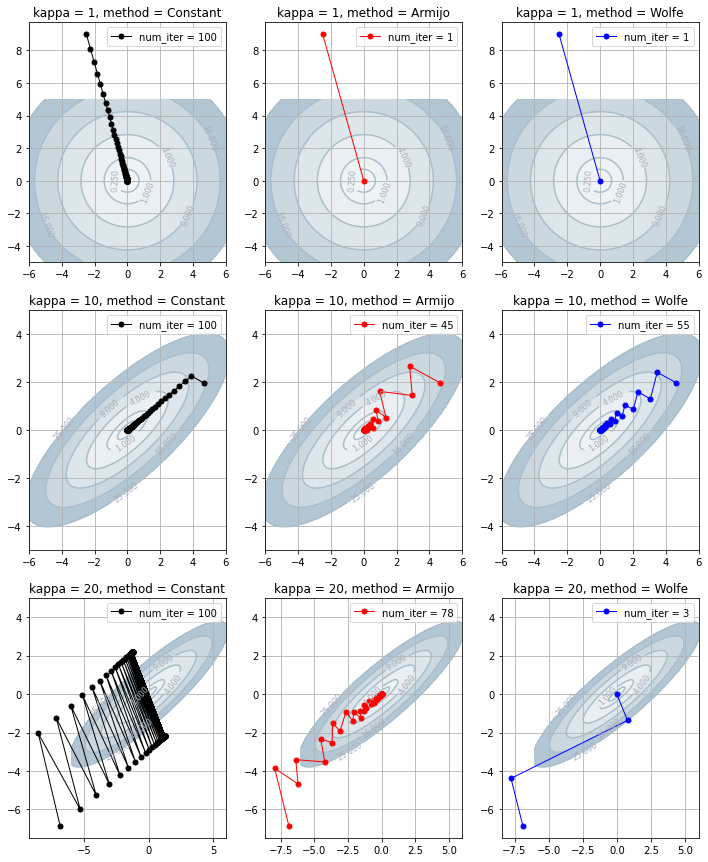

In [4]:
plt.figure(figsize=(12, 15))

theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
S = np.array(((c, -s), (s, c)))

map = {
    'Constant': 'black',
    'Armijo': 'red',
    'Wolfe': 'blue'
}
kappas = (1, 10, 20)
b = np.zeros(2)

for i, kappa in enumerate(kappas):
    A = S @ np.diag([1, kappa]) @ S.T
    oracle = QuadraticOracle(A, b)
    x_0 = np.random.uniform(-10, 10, size=2)

    for j, (method_name, color) in enumerate(map.items()):
        x_star, hist = GradientDescent(
            oracle=oracle, x_0=x_0,
            line_search_options={
                'method': method_name,
                'c': 0.1
            }
        ).run()

        num_iter = len(hist["x"]) - 1

        plt.subplot(3, 3, 3 * i + j + 1)
        plot_levels(oracle.func)
        plot_trajectory(oracle.func, hist['x'], label=f'num_iter = {num_iter}', color=color)
        plt.title(f'kappa = {kappa}, method = {method_name}')
        plt.legend()

plt.show()

Ответ: метод с константным шагом показывает себя хуже всего, при большом числе обусловленности метод либо сходится очень долго (малый шаг), либо не сходится вовсе (большой шаг). Метод выбора шага по правилу Вульфа и Армихо показывают себя примерно одинакого хорошо. Однако метод Вульфа в некоторых случаях может сойтись за очень малое число итераций

## 2.3 Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

Исследуйте, как зависит число итераций, необходимое GD для сходимости, от
- Числа обусловленности целевой функции κ;
- Размерности пространства n.

Для данных параметров n и κ сгенерируйте случайную квадратичную задачу размерности n с числом обусловленности κ. Это можно сделать, как описано в пункте 1.4. На этой задаче запустите метод градиентного спуска с вашей любимой стратегией выбора шага и измерьте число итераций N(n, κ), необходимое для достижения точности $\varepsilon$.

Фиксируя n и варьируя κ, постройте график N(n, κ) против κ. Так как квадратичные задачи генерируются случайно, проведите этот эксперимент несколько раз и получите семейство кривых T(n). Изобразите эти кривые на одном графике.

Постройте такие семейства кривых для разных n (можно перебирать n по логарифмической сетке, например, $n \in [10, 100, 1000]$). Получится несколько наборов кривых: часть красных (для n = 10), часть зелёных (для n = 100), часть синих (для n = 1000) и т.д.

Сделайте выводы. Как полученные результаты согласуются с теорией, т.е. с теоретическими
оценками на число итераций GD?

In [5]:
def calculate_num_iter(n, kappa, method_name):
    b = np.random.uniform(1, kappa, size=n)
    A = np.diag(np.concatenate(([1, kappa], np.random.uniform(1, kappa, size=n-2))))
    assert np.linalg.cond(A) == kappa

    oracle = QuadraticOracle(A, b)
    x_0 = np.zeros(n)
    _, hist = GradientDescent(
        oracle=oracle, x_0=x_0,
        line_search_options={
            'method': method_name,
            'c': 0.1,
            'alpha_0': 1
        }
    ).run()

    num_iter = len(hist['time']) - 1
    return num_iter

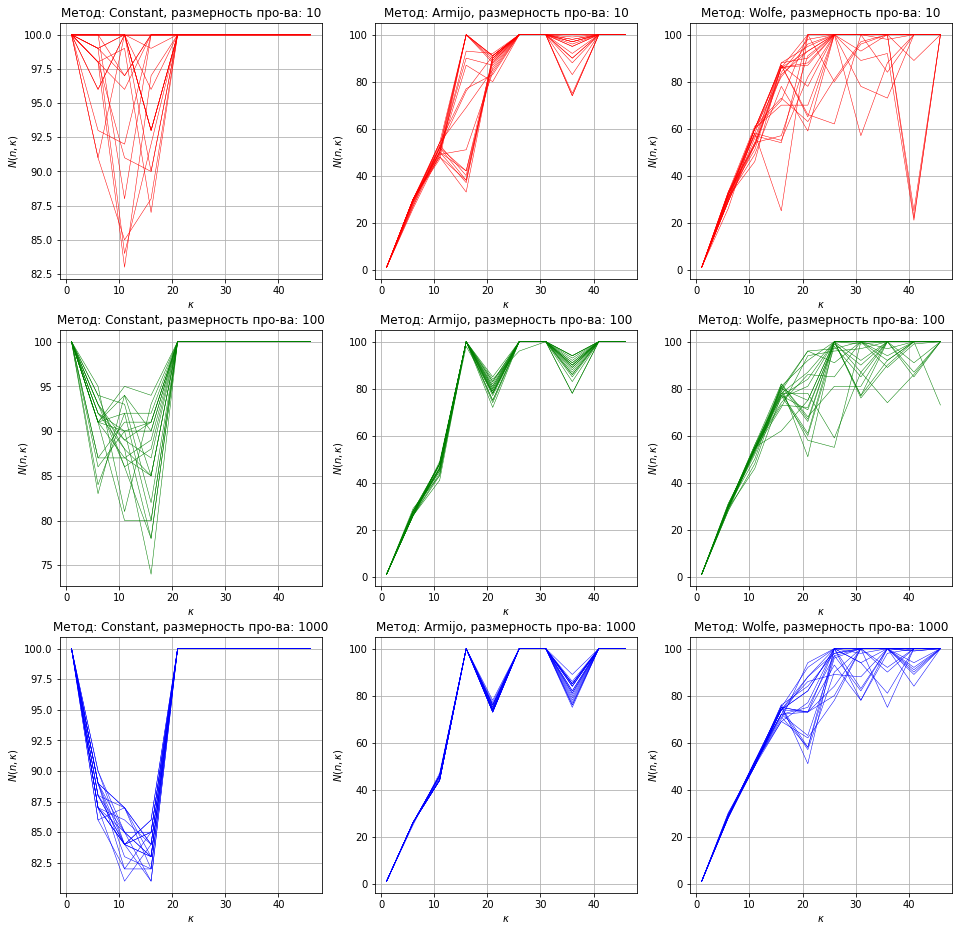

In [6]:
plt.figure(figsize=(16, 16))
n_with_colors = {
    'red': 10,
    'green': 100,
    'blue': 1000
}
num_samples = 20
kappas = range(1, 50, 5)
methods_name = ('Constant', 'Armijo', 'Wolfe')

for i, (color, n) in enumerate(n_with_colors.items()):
    for j, method_name in enumerate(methods_name):
        plt.subplot(3, 3, 3 * i + j + 1)

        for _ in range(num_samples):
            array_of_num_iters = []
            for kappa in kappas:
                array_of_num_iters.append(calculate_num_iter(n, kappa, method_name))
            plt.plot(kappas, array_of_num_iters, color=color, linewidth=0.5)
        
        plt.title(f'Метод: {method_name}, размерность про-ва: {n}')
        plt.grid()
        plt.xlabel(r'$\kappa$')
        plt.ylabel(r'$N(n, \kappa)$')

plt.show()

Ответ:
- В теории градиентный спуск на сильно-выпуклой функции при правильном выбре шага (в идеале $\alpha \leq \frac{2}{\mu + L}$) сходится за линейное число итераций, что согласуется с графиками для метода Армихо и Вульфа.
- Константный метод на графике имеет "яму", из-за того, что шаг для малого числа обусловленности сильно большой.
- Методу Вульфа необходимо в среднем меньше итераций для сходимости, чем методу Армихо (у Армихо "насыщение" до 100 итераций происходит при $\kappa \approx 15$, у Вульфа при $\kappa \approx 25$).
- При увеличении размерности пространства разброс кривых становится меньше

## 2.4 Градиентный спуск на задаче логистической регрессии

- Скачайте датасеты a9a, gisette и real-sim с сайта LIBSVM. Загрузить датасеты в этом формате можно с помощью `sklearn.datasets.load_svmlight_file`.

- Запустите градиентный спуск на задаче логистической регрессии для каждого из датасетов. Постройте кривые, соответствующие разным способам выбора шага (постоянный, Армихо, Вульф), на одном графике. Какой из методов выбора шага работает лучше?

In [2]:
DELETE_FILES_AFTER_DOWNLOAD = True

datasets_links = {
    'a9a.txt': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a',
    'gisette.bz2': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2',
    'real-sim.bz2': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/real-sim.bz2'
}
  
for filename, url in datasets_links.items():
    if not os.path.exists(filename):
        open(filename, 'wb').write(requests.get(url).content)

datasets = {}

for filename in datasets_links.keys():
    datasets[filename] = load_svmlight_file(filename)
    if DELETE_FILES_AFTER_DOWNLOAD:
        os.remove(filename)

In [8]:
datasets

{'a9a.txt': (<32561x123 sparse matrix of type '<class 'numpy.float64'>'
  	with 451592 stored elements in Compressed Sparse Row format>,
  array([-1., -1., -1., ..., -1., -1.,  1.])),
 'gisette.bz2': (<6000x5000 sparse matrix of type '<class 'numpy.float64'>'
  	with 29729997 stored elements in Compressed Sparse Row format>,
  array([ 1., -1.,  1., ..., -1., -1., -1.])),
 'real-sim.bz2': (<72309x20958 sparse matrix of type '<class 'numpy.float64'>'
  	with 3709083 stored elements in Compressed Sparse Row format>,
  array([ 1.,  1.,  1., ..., -1., -1., -1.]))}

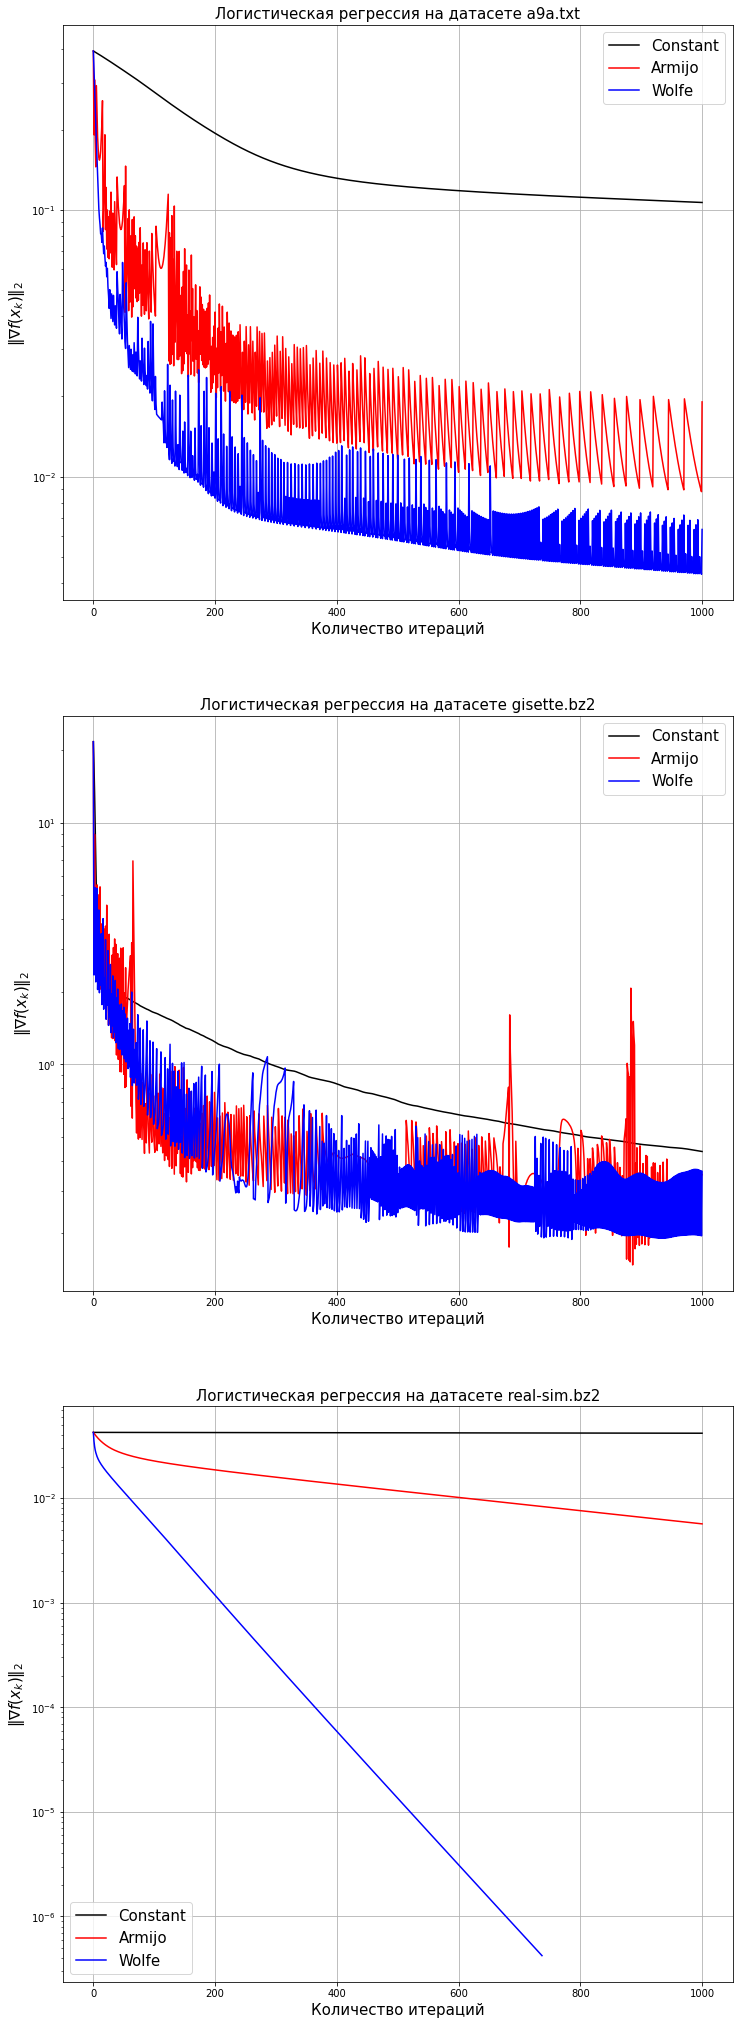

In [3]:
plt.figure(figsize=(12, 36))

for i, (filename, (X, y)) in enumerate(datasets.items()):
    plt.subplot(3, 1, i + 1)
    m, n = X.shape

    oracle = create_log_reg_oracle(X, y, 1 / m)
    x_0 = np.random.uniform(-20, 20, size=n)

    map = {
        'Constant': 'black',
        'Armijo': 'red',
        'Wolfe': 'blue'
    }

    for method_name, color in map.items():
        _, hist = GradientDescent(
                oracle=oracle, x_0=x_0,
                line_search_options={
                    'method': method_name,
                    'alpha_0': 100,
                    'c': 0.1
                }
            ).run(max_iter=1000)
        
        plt.plot(hist['grad_norm'], color=color, label=method_name)

    plt.title(f'Логистическая регрессия на датасете {filename}', fontsize=15)
    plt.xlabel('Количество итераций', fontsize=15)
    plt.ylabel(r'$\Vert \nabla f (x_k) \Vert_2 $', fontsize=15)
    plt.semilogy()
    plt.grid()
    plt.legend(fontsize=15)

plt.show()

Ответ: на всех задачах метод Вульфа показывает себя лучше всего, а константный метод выбора шага хуже всего